In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
from pysheds.grid import Grid
import mplleaflet
%matplotlib inline

In [2]:
grid = Grid.from_raster('../Rst/20190109125130_1063922483_WGS13N.tif', data_name='dem')

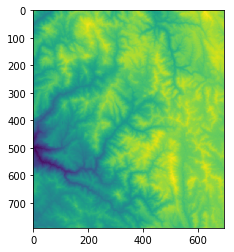

In [3]:
plt.imshow(grid.dem[20:-20,20:-20])

In [4]:
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12,10))
    plt.imshow(data, extent=grid.extent)
    plt.colorbar(label=label)
    plt.grid()

In [5]:
elevDem=grid.dem[:-1,:-1]

In [6]:
#plotFigure(elevDem, 'Elevation (m)')

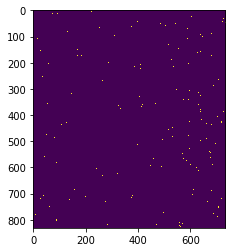

In [7]:
### Detecting depressions

# Detect depressions
depressions = grid.detect_depressions('dem')

# Plot depressions
plt.imshow(depressions)

E:\Software\Anaconda3\lib\site-packages\skimage\morphology\greyreconstruct.py:143: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  selem[[slice(d, d + 1) for d in offset]] = False
E:\Software\Anaconda3\lib\site-packages\skimage\morphology\greyreconstruct.py:161: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  images[[0] + inside_slices] = seed
E:\Software\Anaconda3\lib\site-packages\skimage\morphology\greyreconstruct.py:162: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of

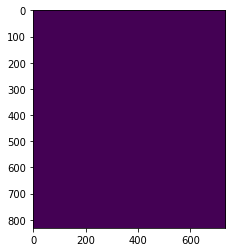

In [8]:
# Fill depressions
grid.fill_depressions(data='dem', out_name='flooded_dem')

# Test result
depressions = grid.detect_depressions('flooded_dem')
plt.imshow(depressions)

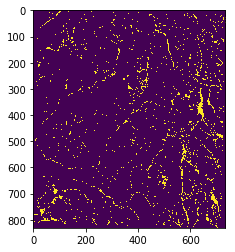

In [9]:
# Detect flats
flats = grid.detect_flats('flooded_dem')

# Plot flats
plt.imshow(flats)

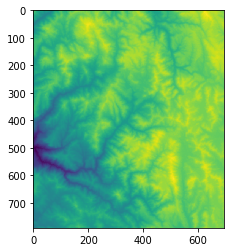

In [10]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')
plt.imshow(grid.inflated_dem[20:-20,20:-20])

In [11]:
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

In [12]:
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

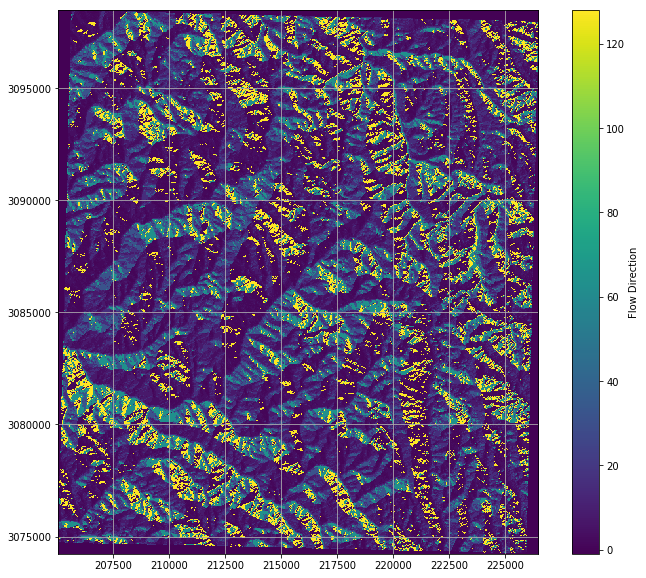

In [13]:
plotFigure(grid.dir,'Flow Direction','viridis')

In [14]:
# Specify pour point
x, y = 212797.232, 3082391.630



# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

In [15]:
# Clip the bounding box to the catchment
grid.clip_to('catch')

In [16]:
# Get a view of the catchment
demView = grid.view('dem', nodata=np.nan)

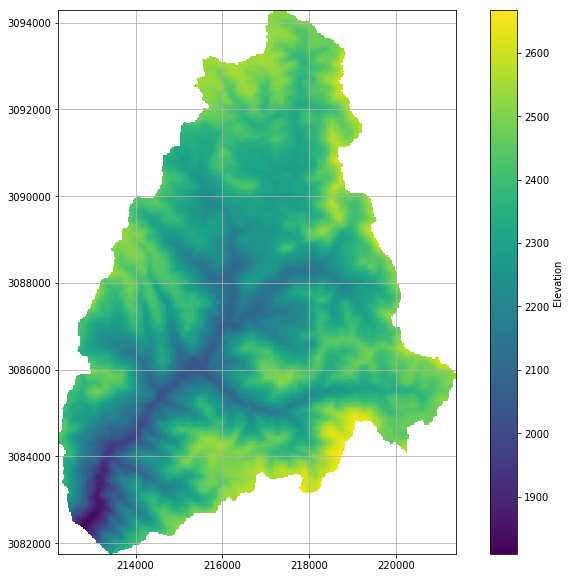

In [17]:
plotFigure(demView,'Elevation')

In [18]:
#export selected raster
grid.to_raster(demView, '../Output/clippedElevations_WGS13N.tif')

In [19]:
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

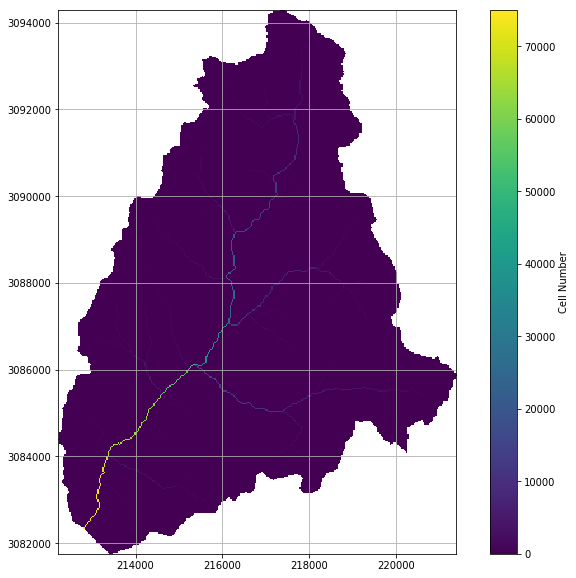

In [20]:
accView = grid.view('acc', nodata=np.nan)
plotFigure(accView,"Cell Number",'PuRd')

In [21]:
streams = grid.extract_river_network('catch', 'acc', threshold=200, dirmap=dirmap)
streams["features"][:2]

[{"geometry": {"coordinates": [[217814.17132098094, 3093123.193799639], [217814.17132098094, 3093152.3505490976], [217814.17132098094, 3093181.507298556], [217785.01457138965, 3093210.6640480147], [217785.01457138965, 3093239.820797473], [217785.01457138965, 3093268.9775469317], [217785.01457138965, 3093298.1342963898], [217785.01457138965, 3093327.2910458483], [217785.01457138965, 3093356.447795307], [217785.01457138965, 3093385.6045447653], [217785.01457138965, 3093414.761294224], [217814.17132098094, 3093443.9180436824], [217814.17132098094, 3093473.074793141], [217843.32807057223, 3093502.2315425994], [217843.32807057223, 3093531.388292058], [217872.48482016352, 3093560.5450415164], [217872.48482016352, 3093589.701790975], [217872.48482016352, 3093618.8585404335], [217872.48482016352, 3093648.015289892], [217872.48482016352, 3093677.1720393505], [217843.32807057223, 3093706.3287888085], [217843.32807057223, 3093735.485538267], [217814.17132098094, 3093764.6422877256], [217814.17132

In [22]:
def saveDict(dic,file):
    f = open(file,'w')
    f.write(str(dic))
    f.close()

In [23]:
#save geojson as separate file
saveDict(streams,'../Output/streams_WGS13N.geojson')

In [24]:
streamNet = gpd.read_file('../Output/streams_WGS13N.geojson')
streamNet.crs = {'init' :'epsg:32613'}

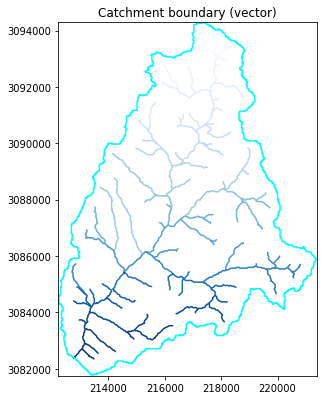

In [25]:
# The polygonize argument defaults to the grid mask when no arguments are supplied
shapes = grid.polygonize()

# Plot catchment boundaries
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Catchment boundary (vector)')
gpd.plotting.plot_dataframe(streamNet, None, cmap='Blues', ax=ax)

In [26]:
#ax = streamNet.plot()
mplleaflet.display(fig=ax.figure, crs=streamNet.crs, tiles='esri_aerial')